# Load dataset old way

In [1]:
import sys
sys.path.append("/net/cci-filer3/home/cschlick/Coding/PhenixML/")
from pathlib import Path
import tqdm
import itertools
import numpy as np
import torch
import matplotlib.pyplot as plt

/net/cci/cschlick/miniconda3/envs/restraintsML/envs/restraintsML6/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# import sys
# sys.path.append(".././phenix_fragments/")
# from mol.mols import Mol
# from graph.molgraph import MolGraph as MolGraphNew
# from graph.molgraph import MolGraphDataset as MolGraphDatasetNew
# from fragmentation.fragmenters import AngleFragmenter

In [3]:
from phenixml.molecule.mol_container import MolContainer, MolContainerList
from phenixml.molecule.fragment import Fragment
from phenixml.utils.rdkit_utils import validate_rdkit_mol
from phenixml.utils.mp_utils import pool_with_progress
import pickle
import joblib
import json

In [4]:
json_file = "/net/cci-filer3/home/cschlick/Coding/PhenixML/notebooks/Poster/COD/COD_containers.json"


In [5]:
#json_file = "/net/cci-filer3/home/cschlick/Coding/PhenixML/notebooks/Poster/COD/COD_containers_debug1000.json"
mols = MolContainerList.from_json_file(json_file,nproc=64)

nproc=64: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 102037/102037 [02:45<00:00, 617.19it/s]


In [6]:
from phenixml.fragmentation.geometry import AngleFragmenter, BondFragmenter
fragmenter =  AngleFragmenter(exclude_elements=["H"])

In [7]:
from phenixml.labelers.geometry import AngleDegreesLabeler
labeler = AngleDegreesLabeler()

In [8]:
from phenixml.featurizers.atom_featurizers import RDKIT_Fingerprint
atom_featurizer = RDKIT_Fingerprint()

In [9]:
from phenixml.graphs.molgraph_dataset import GraphDataSetGenerator, MolGraphDataset
ds_gen = GraphDataSetGenerator(fragmenter=fragmenter,
                               fragment_labeler=labeler,
                               atom_featurizer=atom_featurizer,
                              )

In [10]:
dataset_old = ds_gen(mols,disable_progress=False,nproc=64)

  2%|██▋                                                                                                                    | 2252/102037 [00:43<16:34, 100.38it/s][21:16:06] Can't kekulize mol.  Unkekulized atoms: 1 3 4 5 6
[21:16:06] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 6
[21:16:06] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
  4%|████▋                                                                                                                   | 3953/102037 [01:01<22:26, 72.83it/s][21:16:23] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 9
[21:16:23] Can't kekulize mol.  Unkekulized atoms: 3 4 5 7 9
[21:16:23] Can't kekulize mol.  Unkekulized atoms: 3 4 5 7 9
 19%|██████████████████████▋                                                                                                | 19410/102037 [05:10<17:26, 78.98it/s][21:20:33] Can't kekulize mol.  Unkekulized atoms: 17 29 31 40 41
[21:20:33] Can't kekulize mol.  Unkekulized atoms: 11 24 33 37 43
 35%|████████

# Load dataset new way

In [11]:
import sys
sys.path.append(".././phenix_fragments/")
from mol.mols import Mol
from graph.molgraph import MolGraph as MolGraphNew
from graph.molgraph import MolGraphDataset as MolGraphDatasetNew
from fragmentation.fragmenters import AngleFragmenter
from labeling.labelers import AngleLabeler

ModuleNotFoundError: No module named 'mol'

In [6]:
import json
import tqdm 

with open(json_file,"r") as fh:
  j = json.load(fh)
  mol_files = [e["file"] for e in j["MolContainerList"]]
  
mols_new = []
for file in tqdm.tqdm(mol_files[:10]):
  try:
    mol_new = Mol.from_file_geocif(file)
    mols_new.append(mol_new)
  except:
    pass
  

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 110.03it/s]


In [14]:
mgraphs = []
failed_mols = []
debug = False
for mol in tqdm.tqdm(mols_new):
  try:
    mgraph = MolGraphNew(mol=mol,
                      atom_featurizer=atom_featurizer,
                      fragmenter=AngleFragmenter(exclude_elements=["H"]),
                      labelers = {"angle_value":lambda frags: frags.angle_value},
                                 
                      skip_hydrogens=True,
                      frag_name="fragment")
    mgraphs.append(mgraph)
  except:
    failed_mols.append(mol)
    if debug:
      raise

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 954/954 [00:07<00:00, 125.19it/s]


In [15]:
dataset_new = MolGraphDatasetNew(mgraphs)

In [16]:
# make sure same files and same order
files_canon = []
files = [str(mgraph.mol_container.file) for mgraph in dataset]
files_new = [mgraph.mol.mol_input.file for mgraph in dataset_new]
for file in files:
  if file in files_new:
    files_canon.append(file)

In [17]:
mgraphs_old = [mgraph for mgraph in dataset if str(mgraph.mol_container.file) in files_canon]
mgraphs_new = [mgraph for mgraph in dataset_new if mgraph.mol.mol_input.file in files_canon]

mgraphs_old_matched = []
mgraphs_new_matched = []
for i,(m1,m2) in enumerate(zip(mgraphs_old,mgraphs_new)):
  l1,l2 = len(m1.fragments), len(m2.fragments)
  if l1==l2:
    mgraphs_old_matched.append(m1)
    mgraphs_new_matched.append(m2)
dataset_old = MolGraphDataset(mgraphs_old_matched)
dataset_new = MolGraphDatasetNew(mgraphs_new_matched)

In [18]:
assert torch.all((dataset_old.heterograph.nodes["atom"].data["h0"]==
                  dataset_new.fragment_graph.nodes["atom"].data["h0"]))
assert torch.all((dataset_old.heterograph.nodes["fragment"].data["idxs"]==
                  dataset_new.fragment_graph.nodes["fragment"].data["graph_node_index"]))

In [19]:
assert (dataset_new[0].fragment_graph.nodes["atom"].data["h0"].shape[1]==
        dataset_old[0].heterograph.nodes["atom"].data["h0"].shape[1])


# Old data old model

In [12]:
# make model
import torch.nn as nn
from phenixml.models.message_passing import MessagePassing
from phenixml.models.readout import ReadoutLinearJanossy

# settings
gpuid = 2
n_units = 128
n_layers_mp = 4
fragment_size = 3
n_atom_features = dataset_old[0].heterograph.nodes["atom"].data["h0"].shape[1]
feature_units = n_atom_features


# Set up message passing
config = []
for n_layer in range(n_layers_mp):
  config+=[n_units,"relu"]

message_passing = MessagePassing(
    feature_units=feature_units) 


# Set up readout
n_layers_readout = 3
config = []
for n_layer in range(n_layers_readout):
  config+=[n_units,"relu"]
  
readout = ReadoutLinearJanossy(
    in_features=n_units, 
    config=config,
    out_features={"angle_value_pred":1},
    fragment_size = fragment_size)

# Sequential message passing, readout
model = nn.Sequential(message_passing,readout)
opt = torch.optim.Adam(model.parameters(),lr=1e-4)
metric = torch.nn.MSELoss()

if gpuid is not None:
  model = model.to("cuda:"+str(gpuid))

In [13]:
# set up dataset, train/test split
dataset_train_old, dataset_test_old = dataset_old.train_test_split(test_fraction=0.1)
batches_old = list(dataset_train_old.batches(batch_size=10000))

In [14]:
# Training loop
if gpuid is not None:
  model = model.to("cuda:"+str(gpuid))

epoch_losses = []
n_epoch=500

for epoch in tqdm.tqdm(range(n_epoch)):
  batch_losses = []
  for batch in batches_old:
    if gpuid is not None:
      batch = batch.to("cuda:"+str(gpuid))
    g = model(batch)
    loss = metric(g.nodes["fragment"].data["ref"],
                  g.nodes["fragment"].data["angle_value_pred"])
    opt.zero_grad()
    loss.backward()
    opt.step()
    batch_losses.append(loss.item())

  epoch_losses.append(np.mean(batch_losses))
  


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 410/500 [13:18<02:55,  1.95s/it]


KeyboardInterrupt: 

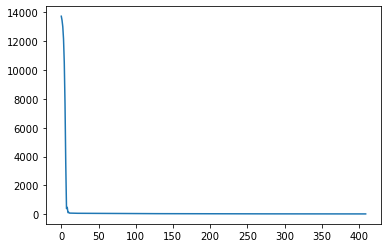

In [15]:
plt.plot(epoch_losses)

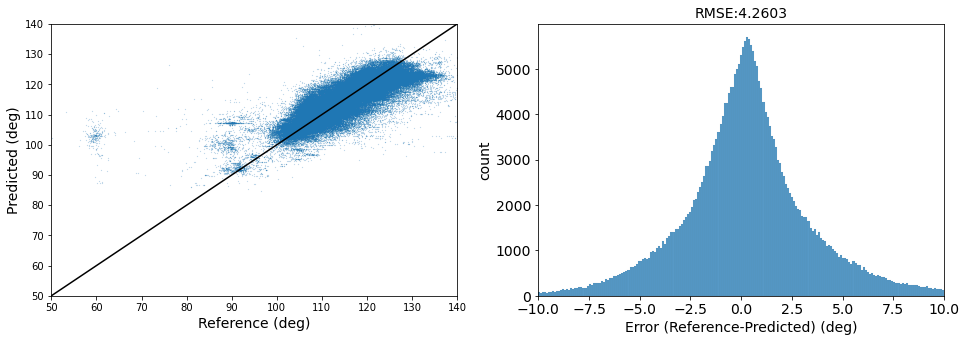

In [17]:
from phenixml.utils.torch_utils import to_torch, to_np
from phenixml.visualization.plotting import plot_geom_eval
from collections import defaultdict

if gpuid is not None:
  model = model.to("cpu")
test_batch = model(dataset_test_old.heterograph)
a,b = (test_batch.nodes["fragment"].data["ref"], 
       test_batch.nodes["fragment"].data["angle_value_pred"])
a,b = to_np(a).flatten(),to_np(b).flatten()
#a,b = np.degrees(a), np.degrees(b)
plot_geom_eval(a,b,mode="angle")

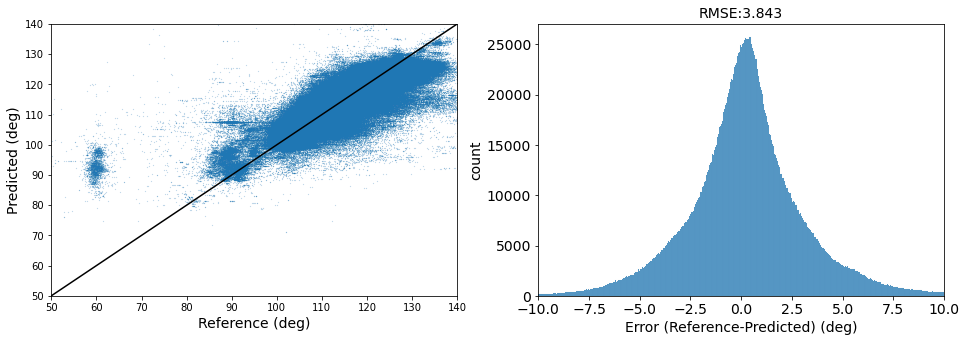

In [16]:
from phenixml.utils.torch_utils import to_torch, to_np
from phenixml.visualization.plotting import plot_geom_eval
from collections import defaultdict

if gpuid is not None:
  model = model.to("cpu")
full_batch = model(dataset_old.heterograph)
a,b = (full_batch.nodes["fragment"].data["ref"], 
       full_batch.nodes["fragment"].data["angle_value_pred"])
a,b = to_np(a).flatten(),to_np(b).flatten()
#a,b = np.degrees(a), np.degrees(b)
plot_geom_eval(a,b,mode="angle")

# Old data new model

In [17]:
import sys
sys.path.append("/net/cci-filer3/home/cschlick/Coding/phenix_fragments/phenix_fragments/")
from graph.message_passing import MessagePassingBonded
from graph.readout import ReadoutJanossyLinear

In [20]:

label_name = "angle_value"
batches = list(dataset_train_old.batches(batch_size=10000))
atom_feature_shape = tuple(g.nodes["atom"].data["h0"].shape)
hidden_units = 64
message_passing = MessagePassingBonded(feature_units=atom_feature_shape[1],
                                       hidden_units=hidden_units,
                                       nlayers=4,
                                       )

#readout = ReadoutSimpleLinear(hidden_units*2,hidden_units*2,1,n_hid_layers=1,label_name=label_name)
fragment_size = 3
# readout = ReadoutSimple(hidden_units,
#                         hidden_units,
#                         1,
#                         n_hid_layers=3,
#                         fragment_size=fragment_size,
#                         label_name=label_name)
readout = ReadoutJanossyLinear(hidden_units*fragment_size,
                               hidden_units*fragment_size,
                               1,
                               n_hid_layers=3,
                               label_name=label_name,
                               fragment_size=fragment_size)

model = torch.nn.Sequential(message_passing,readout)
opt = torch.optim.Adam(model.parameters(),lr=1e-4)
metric = torch.nn.MSELoss()

In [21]:
# Training loop
if gpuid is not None:
  model = model.to("cuda:"+str(gpuid))

epoch_losses = []
n_epoch=500

for epoch in tqdm.tqdm(range(n_epoch)):
  batch_losses = []
  for batch in batches_old:
    if gpuid is not None:
      batch = batch.to("cuda:"+str(gpuid))
    g = model(batch)
    loss = metric(g.nodes["fragment"].data["ref"],
                  g.nodes["fragment"].data["angle_value_pred"])
    opt.zero_grad()
    loss.backward()
    opt.step()
    batch_losses.append(loss.item())

  epoch_losses.append(np.mean(batch_losses))
  

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [06:03<00:00,  1.38it/s]


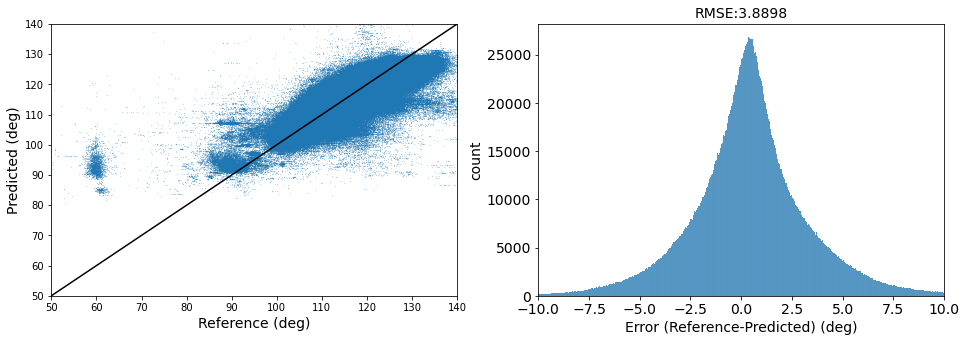

In [22]:
from phenixml.utils.torch_utils import to_torch, to_np
from phenixml.visualization.plotting import plot_geom_eval
from collections import defaultdict

if gpuid is not None:
  model = model.to("cpu")
full_batch = model(dataset_old.heterograph)
a,b = (full_batch.nodes["fragment"].data["ref"], 
       full_batch.nodes["fragment"].data["angle_value_pred"])
a,b = to_np(a).flatten(),to_np(b).flatten()
#a,b = np.degrees(a), np.degrees(b)
plot_geom_eval(a,b,mode="angle")

# New data, new model

In [1]:
import sys
sys.path.append("../../phenix_fragments/")
from frag.mol.mols import Mol
from frag.graph.molgraph import MolGraph as MolGraphNew
from frag.graph.molgraph import MolGraphDataset as MolGraphDatasetNew
from frag.fragmentation.fragmenters import AngleFragmenter
from frag.labeling.labelers import AngleLabeler
from frag.featurization.atom_featurizers import RDKITFingerprint

from frag.graph.message_passing import MessagePassingBonded
from frag.graph.readout import ReadoutJanossyLinear

/net/cci/cschlick/miniconda3/envs/restraintsML/envs/restraintsML6/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
fragmenter = AngleFragmenter()
atom_featurizer = RDKITFingerprint()
labeler = AngleLabeler()

In [3]:
json_file = "/net/cci-filer3/home/cschlick/Coding/PhenixML/notebooks/Poster/COD/COD_containers.json"



In [4]:
import json
import tqdm 

with open(json_file,"r") as fh:
  j = json.load(fh)
  mol_files = [e["file"] for e in j["MolContainerList"]]
  
mols_new = []
for file in tqdm.tqdm(mol_files):
  try:
    mol_new = Mol.from_file_geocif(file)
    mols_new.append(mol_new)
  except:
    pass
  

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 102037/102037 [12:33<00:00, 135.39it/s]


In [5]:
mgraphs_new = []
failed_mols = []
debug = False
for mol in tqdm.tqdm(mols_new):
  try:
    mgraph = MolGraphNew(mol=mol,
                      atom_featurizer=atom_featurizer,
                      fragmenter=fragmenter,
                      labelers = {labeler.label_name:labeler},
                                 
                      skip_hydrogens=False,
                      frag_name="fragment")
    mgraphs_new.append(mgraph)
  except:
    failed_mols.append(mol)
    if debug:
      raise

 28%|█████████████████████████████████▊                                                                                      | 27402/97189 [07:09<21:28, 54.17it/s][10:59:58] 

****
Pre-condition Violation
bond already exists
Violation occurred on line 334 in file /home/conda/feedstock_root/build_artifacts/rdkit_1654409067822/work/Code/GraphMol/RWMol.cpp
Failed Expression: !(boost::edge(atomIdx1, atomIdx2, d_graph).second)
****

 40%|████████████████████████████████████████████████                                                                        | 38876/97189 [10:09<23:54, 40.66it/s][11:02:59] 

****
Pre-condition Violation
bond already exists
Violation occurred on line 334 in file /home/conda/feedstock_root/build_artifacts/rdkit_1654409067822/work/Code/GraphMol/RWMol.cpp
Failed Expression: !(boost::edge(atomIdx1, atomIdx2, d_graph).second)
****

 41%|████████████████████████████████████████████████▋                                                                       | 39422/971

In [6]:
dataset_new = MolGraphDatasetNew(mgraphs_new)

In [7]:
# set up dataset, train/test split
dataset_train_new, dataset_test_new = dataset_new.train_test_split(test_fraction=0.1)
batches_new = list(dataset_train_new.batches(batch_size=10000))

In [8]:
import torch
import numpy as np

label_name = "angle_value"
atom_feature_shape = tuple(dataset_new[0].fragment_graph.nodes["atom"].data["h0"].shape)
hidden_units = 64
message_passing = MessagePassingBonded(feature_units=atom_feature_shape[1],
                                       hidden_units=hidden_units,
                                       nlayers=4,
                                       )

#readout = ReadoutSimpleLinear(hidden_units*2,hidden_units*2,1,n_hid_layers=1,label_name=label_name)
fragment_size = 3
# readout = ReadoutSimple(hidden_units,
#                         hidden_units,
#                         1,
#                         n_hid_layers=3,
#                         fragment_size=fragment_size,
#                         label_name=label_name)
readout = ReadoutJanossyLinear(hidden_units*fragment_size,
                               hidden_units*fragment_size,
                               1,
                               n_hid_layers=3,
                               label_name=label_name,
                               fragment_size=fragment_size)

model = torch.nn.Sequential(message_passing,readout)
opt = torch.optim.Adam(model.parameters(),lr=1e-4)
metric = torch.nn.MSELoss()

In [9]:
# Training loop

gpuid=2

if gpuid is not None:
  model = model.to("cuda:"+str(gpuid))

epoch_losses = []
n_epoch=500

for epoch in tqdm.tqdm(range(n_epoch)):
  batch_losses = []
  for batch in batches_new:
    if gpuid is not None:
      batch = batch.to("cuda:"+str(gpuid))
    g = model(batch)
    loss = metric(g.nodes["fragment"].data["angle_value"],
                  g.nodes["fragment"].data["angle_value_pred"])
    opt.zero_grad()
    loss.backward()
    opt.step()
    batch_losses.append(loss.item())

  epoch_losses.append(np.mean(batch_losses))
  

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [11:44<00:00,  1.41s/it]


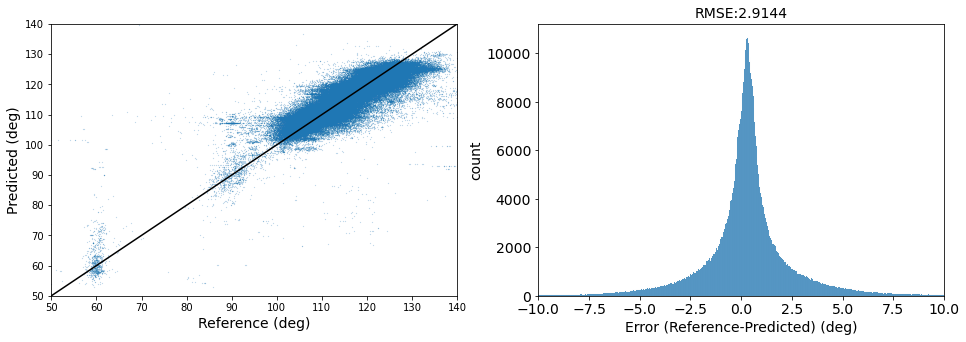

In [10]:
from frag.utils.torch import to_np, to_torch
from frag.utils.plotting import plot_geom_eval

if gpuid is not None:
  model = model.to("cpu")
test_batch = model(dataset_test_new.fragment_graph)
a,b = (test_batch.nodes["fragment"].data["angle_value"], 
       test_batch.nodes["fragment"].data["angle_value_pred"])
a,b = to_np(a).flatten(),to_np(b).flatten()
#a,b = np.degrees(a), np.degrees(b)
plot_geom_eval(a,b,mode="angle")

In [15]:
mgraphs_new[0].mol.mol_input.file

'/dev/shm/cschlick/CODoutput/cif/8/10/52/8105236_001_geo.cif'

In [19]:
dataset_new.fragment_graph.nodes["atom"].data["h0"].sum()

tensor(55047824.)

In [21]:
torch.save(model,"../pretrained/angle_model.pkl")

In [25]:
mols_new[1000].mol_input.file

'/dev/shm/cschlick/CODoutput/cif/7/70/68/7706849_000_geo.cif'

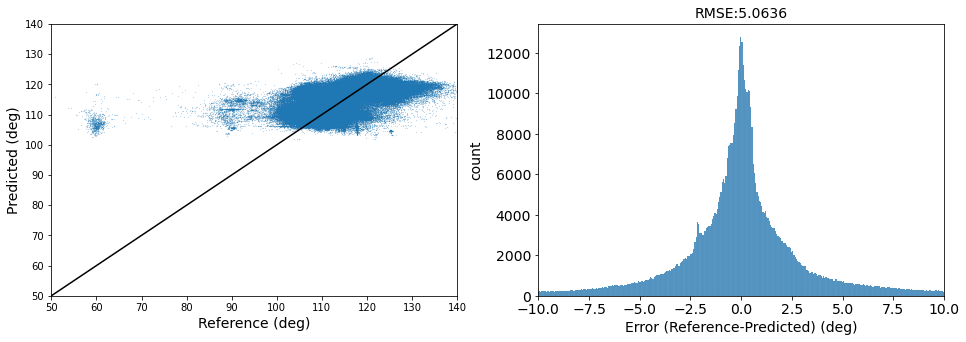

In [13]:
from frag.utils.torch import to_np, to_torch
from frag.utils.plotting import plot_geom_eval

if gpuid is not None:
  model = model.to("cpu")
test_batch = model(dataset_test_new.fragment_graph)
a,b = (test_batch.nodes["fragment"].data["angle_value"], 
       test_batch.nodes["fragment"].data["angle_value_pred"])
a,b = to_np(a).flatten(),to_np(b).flatten()
#a,b = np.degrees(a), np.degrees(b)
plot_geom_eval(a,b,mode="angle")

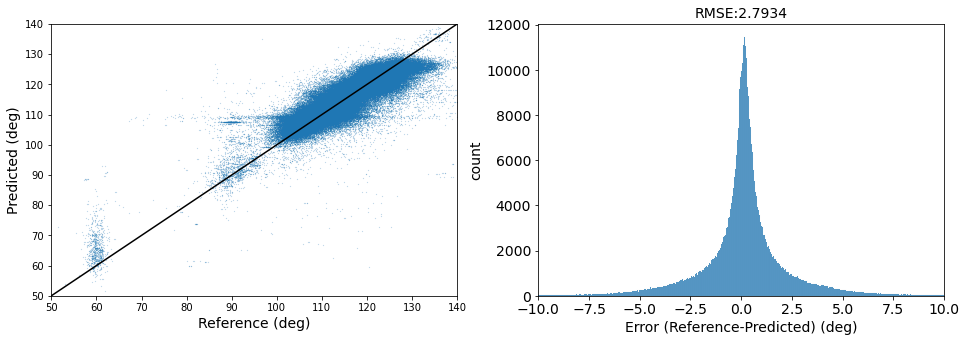

In [48]:
from phenixml.utils.torch_utils import to_torch, to_np
from phenixml.visualization.plotting import plot_geom_eval
from collections import defaultdict

if gpuid is not None:
  model = model.to("cpu")
test_batch = model(dataset_test_new.fragment_graph)
a,b = (test_batch.nodes["fragment"].data["angle_value"], 
       test_batch.nodes["fragment"].data["angle_value_pred"])
a,b = to_np(a).flatten(),to_np(b).flatten()
#a,b = np.degrees(a), np.degrees(b)
plot_geom_eval(a,b,mode="angle")

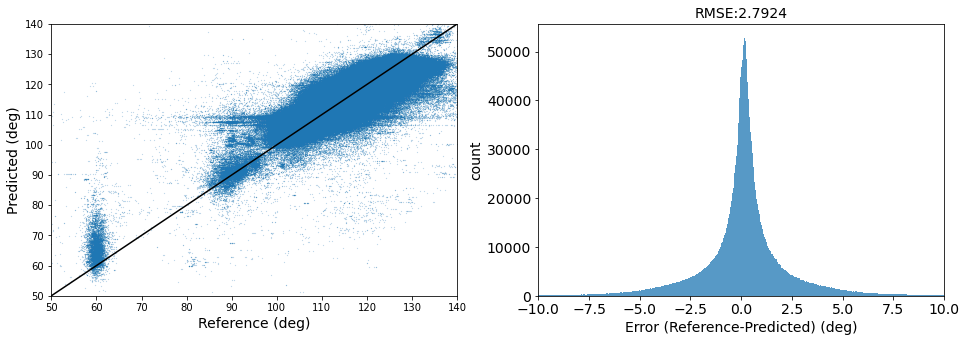

In [49]:
from phenixml.utils.torch_utils import to_torch, to_np
from phenixml.visualization.plotting import plot_geom_eval
from collections import defaultdict

if gpuid is not None:
  model = model.to("cpu")
full_batch = model(dataset_new.fragment_graph)
a,b = (full_batch.nodes["fragment"].data["angle_value"], 
       full_batch.nodes["fragment"].data["angle_value_pred"])
a,b = to_np(a).flatten(),to_np(b).flatten()
#a,b = np.degrees(a), np.degrees(b)
plot_geom_eval(a,b,mode="angle")

In [21]:
ds_gen = GraphDataSetGenerator(fragmenter=fragmenter,
                               fragment_labelers={labeler.label_name:labeler},
                               atom_featurizer=atom_featurizer)

In [25]:
ds = ds_gen(mols_new)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 48.73it/s]


AttributeError: 'MolGraphDataset' object has no attribute 'features'